/tmp/ipykernel_2809988/2519274693.py:65: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(M_range, phi_schechter_fit, 'k-', linewidth=1.5, linestyle='--')
/tmp/ipykernel_2809988/2519274693.py:65: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(M_range, phi_schechter_fit, 'k-', linewidth=1.5, linestyle='--')
/tmp/ipykernel_2809988/2519274693.py:65: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(M_range, phi_schechter_fit, 'k-', linewidth=1.5, linestyle='--')
/tmp/ipykernel_2809988/2519274693.py:65: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k-

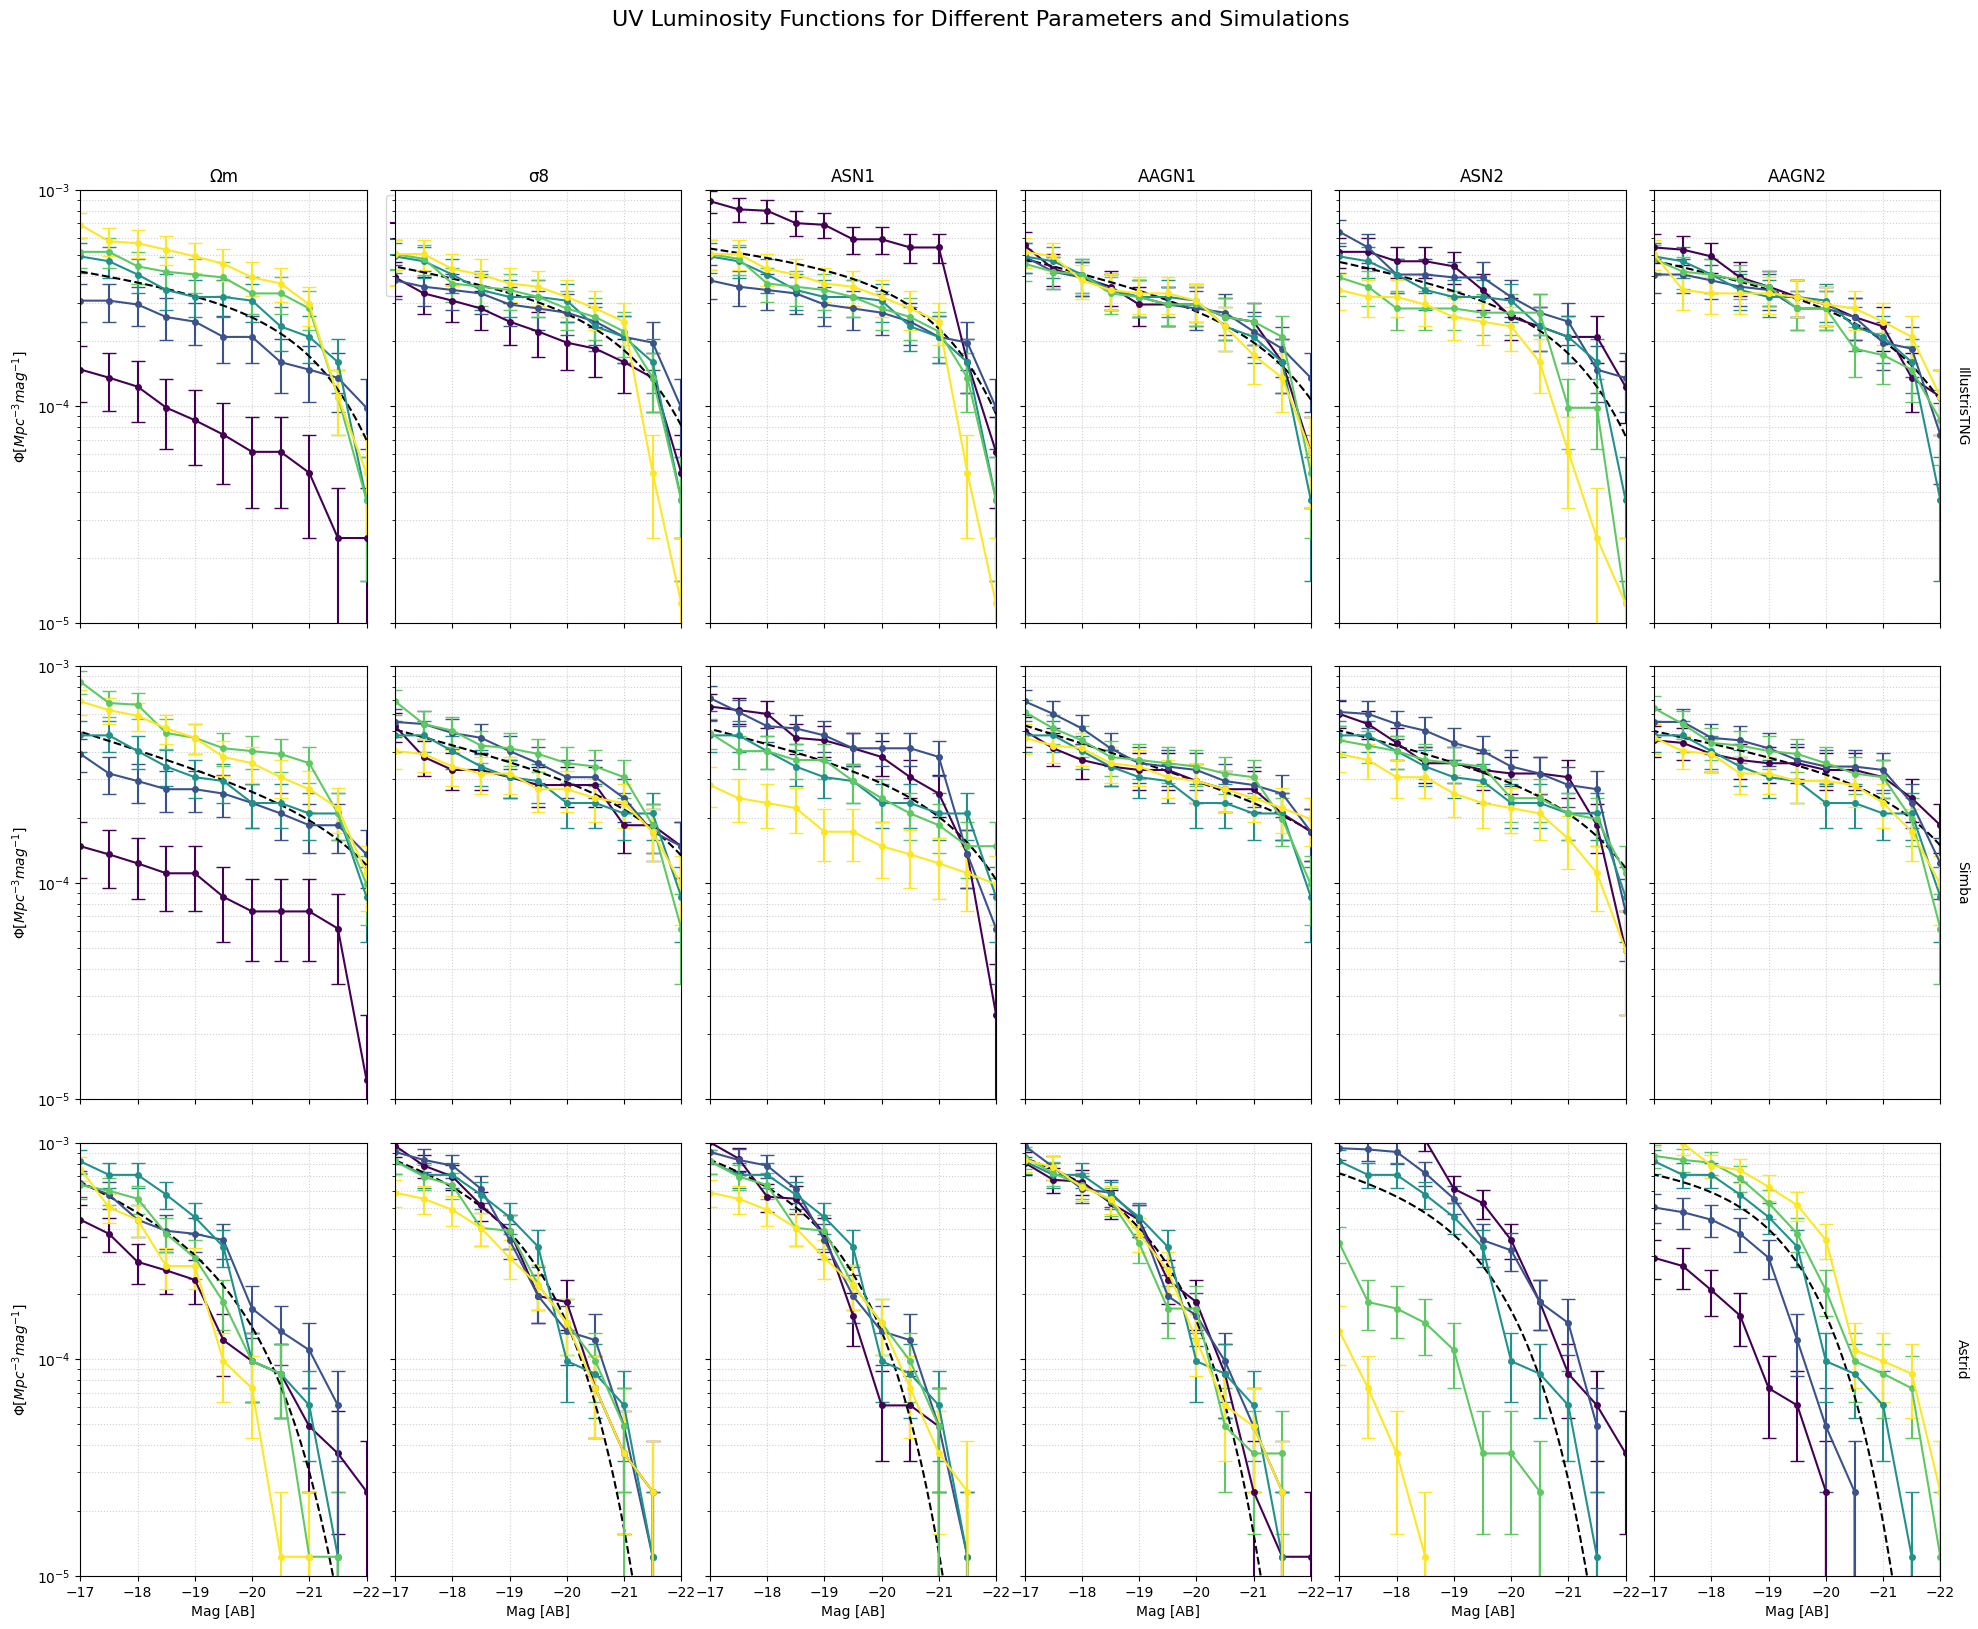

Plot saved as UVLF_multi_panel.png


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
import os

# Schechter function
def schechter(M, alpha, M_star, phi_star):
    return 0.4 * np.log(10) * phi_star * (10 ** (0.4 * (M_star - M))) ** (alpha + 1) * np.exp(-10 ** (0.4 * (M_star - M)))

# Define parameters and simulations
parameters = ['OmegaM', 'Sigma8', 'SN1', 'AGN1', 'SN2', 'AGN2']
param_labels = ['Ωm', 'σ8', 'ASN1', 'AAGN1', 'ASN2', 'AAGN2']
simulations = ['IllustrisTNG', 'Simba', 'Astrid']
sim_names = ['IllTNG', 'SIMBA', 'Astrid']

# Set up the plot
fig, axes = plt.subplots(len(simulations), len(parameters), figsize=(24, 18), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.1, wspace=0.1)

# Define mass bin limits
massBinLimits = np.arange(-22, -16, 0.5)

# Color map for different parameter values
colors = plt.cm.viridis(np.linspace(0, 1, 5))  # Assuming 5 different values per parameter

# Function to read UVLF data from file
def read_uvlf_data(filename):
    return pd.read_csv(filename, delim_whitespace=True)

# Plot UVLFs
for i, (sim, sim_name) in enumerate(zip(simulations, sim_names)):
    for j, (param, param_label) in enumerate(zip(parameters, param_labels)):
        ax = axes[i, j]
        
        # Read and plot data for each parameter value
        #/disk/xray15/aem2/camels/proj1/1P_set/1P_outputs/IllustrisTNG/LF_1P_AGN1_IllTNG.txt
        #filename = f"/home/jovyan/camels/proj1/1P_set/1P_outputs/{sim}/LF_1P_{param}_{sim_name}.txt"
        filename = f"/disk/xray15/aem2/camels/proj1/1P_set/1P_outputs/{sim}/LF_1P_{param}_{sim_name}.txt"
        try:
            df = read_uvlf_data(filename)
            
            param_values = df[param].unique()
            all_M = []
            all_phi = []
            for k, param_value in enumerate(param_values):
                subset = df[df[param] == param_value].sort_values('hist')
                
                ax.errorbar(massBinLimits[:-1], subset['phi'], yerr=subset['phi_sigma'], 
                            fmt='o-', color=colors[k], label=f'{param} = {param_value:.2f}', 
                            capsize=5, markersize=4, linewidth=1.5)
                
                all_M.extend(massBinLimits[:-1])
                all_phi.extend(subset['phi'])
            
            # Fit Schechter function
            all_M = np.array(all_M)
            all_phi = np.array(all_phi)
            initial_guess = [-1.55, -19.49, 1.69e-3]
            popt, _ = curve_fit(schechter, all_M, all_phi, p0=initial_guess)
            
            # Plot fitted Schechter function
            M_range = np.linspace(min(all_M), max(all_M), 100)
            phi_schechter_fit = schechter(M_range, *popt)
            ax.plot(M_range, phi_schechter_fit, 'k-', linewidth=1.5, linestyle='--')
            
        except FileNotFoundError:
            print(f"File not found: {filename}")
        except Exception as e:
            print(f"Error processing {filename}: {str(e)}")
        
        # Set labels and titles
        if i == len(simulations) - 1:
            ax.set_xlabel('Mag [AB]')
        if j == 0:
            ax.set_ylabel('$\Phi [Mpc^{-3} mag^{-1}]$')
        if i == 0:
            ax.set_title(param_label)
        
        # Set axis properties
        ax.set_yscale('log')
        ax.set_xlim(-22, -17)
        ax.set_ylim(1e-5, 1e-3)
        ax.invert_xaxis()
        ax.grid(True, which='both', linestyle=':', alpha=0.6)
        
        # Add simulation name to the right side of the rightmost plot
        if j == len(parameters) - 1:
            ax.text(1.05, 0.5, sim, transform=ax.transAxes, rotation=-90, va='center')

        # Add legend to the first plot only
        if i == 0 and j == 0:
            ax.legend(title='Parameter value', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

# Add overall title
fig.suptitle('UV Luminosity Functions for Different Parameters and Simulations', fontsize=16)

# Save the figure
plt.savefig('UVLF_multi_panel.png', dpi=300, bbox_inches='tight')
plt.show()
#plt.close()
print("Plot saved as UVLF_multi_panel.png")

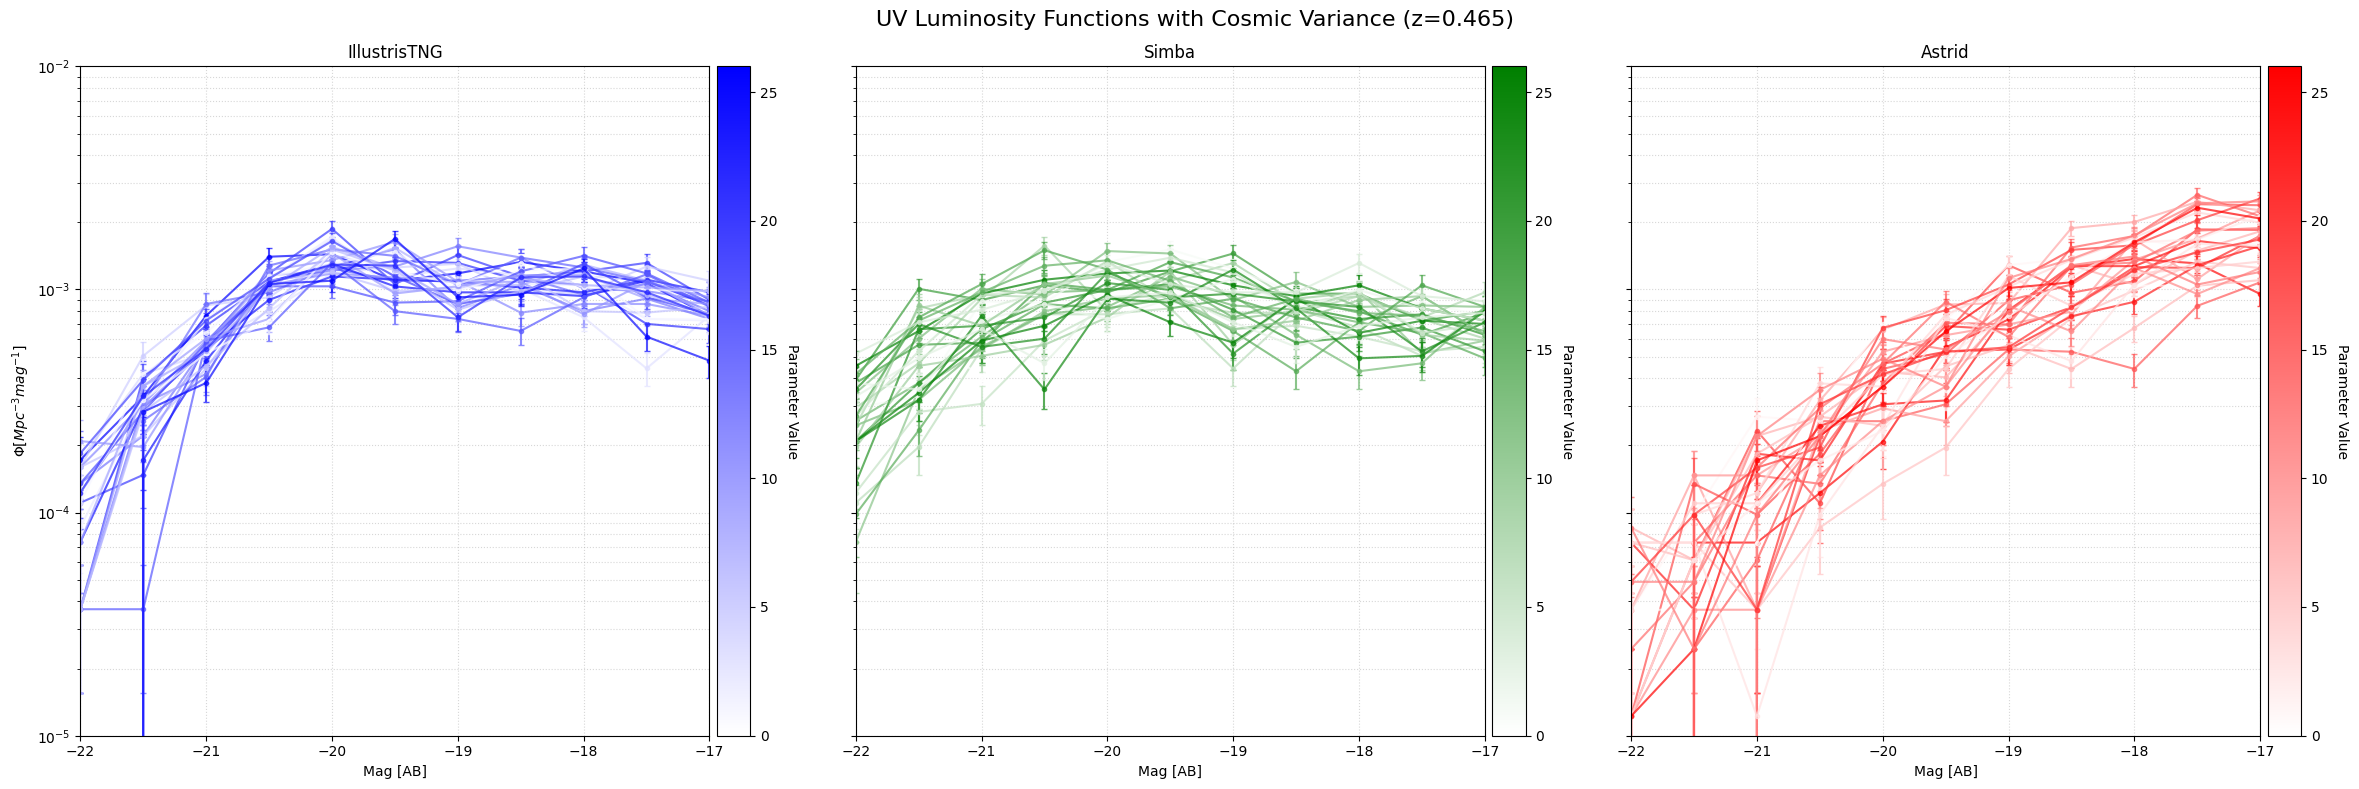

In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def process_simulation(directory):
    files = os.listdir(directory)
    CV_X_files = [file for file in files if file.startswith("CV_") and file.endswith(".txt")]

    phia, phi_sigmaa, binsa, CV_X_values = [], [], [], []

    for CV_X_file in CV_X_files:
        file_path = os.path.join(directory, CV_X_file)
        CV_X = CV_X_file[:-4]
        variable_data = {}

        with open(file_path, 'r') as file:
            current_variable_name = None
            current_variable_values = []

            for line in file:
                line = line.strip()
                if not line:
                    continue
                if line in ['phi', 'phi_sigma', 'hist', 'massBinLimits']:
                    if current_variable_name is not None:
                        variable_data[current_variable_name] = current_variable_values
                        current_variable_values = []
                    current_variable_name = line
                else:
                    current_variable_values.append(float(line))

            if current_variable_name is not None:
                variable_data[current_variable_name] = current_variable_values

        phia.append(variable_data.get('phi'))
        phi_sigmaa.append(variable_data.get('phi_sigma'))
        binsa.append(variable_data.get('massBinLimits'))
        CV_X_values.append(float(CV_X.split('_')[-1]))

    return pd.DataFrame({'CV_X': CV_X_values, 'phi': phia, 'phi_sigma': phi_sigmaa, 'bins': binsa})

def plot_simulation(ax, df, simulation_name, cmap):
    phi_arrays = np.array(df['phi'].tolist())
    phi_sigma_arrays = np.array(df['phi_sigma'].tolist())
    massBinLimits = df['bins'].iloc[0]
    param_values = df['CV_X'].values

    for i, (phi, phi_sigma, param_value) in enumerate(zip(phi_arrays, phi_sigma_arrays, param_values)):
        color = cmap((param_value - param_values.min()) / (param_values.max() - param_values.min()))
        ax.errorbar(massBinLimits[:-1], phi, yerr=phi_sigma, fmt='o-', color=color, alpha=0.7, markersize=3, capsize=2)

    ax.set_xlabel('Mag [AB]')
    ax.set_title(simulation_name)
    ax.grid(True, which='both', linestyle=':', alpha=0.5)
    ax.set_xlim(-22, -17)
    ax.set_ylim(1e-5, 1e-2)

# Main script
base_directory = "/disk/xray15/aem2/camels/proj1/CV_set/CV_outputs/LFs"
simulations = ["IllustrisTNG", "Simba", "Astrid"]
colors = ["blue", "green", "red"]  # Base colors for IllustrisTNG, Simba, and Astrid respectively

fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharey=True)
fig.suptitle('UV Luminosity Functions with Cosmic Variance (z=0.465)', fontsize=16)

for i, (simulation, base_color) in enumerate(zip(simulations, colors)):
    directory = os.path.join(base_directory, simulation)
    df = process_simulation(directory)
    
    # Create a custom colormap for each simulation
    cmap = LinearSegmentedColormap.from_list("custom", ["white", base_color])
    
    plot_simulation(axes[i], df, simulation, cmap)
    
    # Only add y-label to the first subplot
    if i == 0:
        axes[i].set_ylabel('$\Phi [Mpc^{-3} mag^{-1}]$')

    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=df['CV_X'].min(), vmax=df['CV_X'].max()))
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=axes[i], pad=0.01)
    cbar.set_label('Parameter Value', rotation=270, labelpad=15)

# Set y-scale for all subplots
for ax in axes:
    ax.set_yscale('log')

plt.tight_layout()
plt.savefig("/disk/xray15/aem2/camels/proj1/CV_set/CV_outputs/plots/UVLF_Mean_CV_Combined_2.png", dpi=300, bbox_inches='tight')
plt.show()